In [4]:
import cv2
import os
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

In [5]:
DATASET_PATH = r'./images'

DATE_IMAGE_WIDTH = 320
DATE_IMAGE_HEIGHT = 80

SEGMENTED_OUTPUT_DIRECTORY = r'./segmented-images'

PYTESSERACT_CONFIG = r'--psm 10 -c tessedit_char_whitelist=0123456789/.'
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\WL23-1\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

In [6]:
def preprocess_date_image(image):
    original_image = cv2.resize(image, (DATE_IMAGE_WIDTH, DATE_IMAGE_HEIGHT))
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    _, th3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    black_count = np.sum(th3 == 0)
    white_count = np.sum(th3 == 255)

    if black_count < white_count:
        image = cv2.bitwise_not(th3)
    else:
        image = th3
    
    # image = cv2.dilate(image, np.ones((1, 1), np.uint8), iterations=1)
    
    return image, original_image

In [7]:
def segmentate_horizontal(image):
    vertical_pixel_count = np.sum(image == 255, axis=0)

    images = []
    current_x = 0
    is_character = False
    for index, count in enumerate(vertical_pixel_count):
        if count == 0:
            if is_character:
                # if index - current_x > 20:
                images.append(image[:, current_x:index])
                is_character = False
            current_x = index
        else:
            is_character = True
        
    return images


def segmentate_vertical(image):
    horizontal_pixel_count = np.sum(image == 255, axis=1)

    current_y = 0
    is_character = False
    for index, count in enumerate(horizontal_pixel_count):
        if count == 0:
            if is_character:
                image = image[current_y:index, :]
                break
            current_y = index
        else:
            is_character = True

    return image

def segment_image(image):
    images = segmentate_horizontal(image)
    
    images = [segmentate_vertical(image) for image in images]

    images = [cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0]) for image in images]
            
    return images

In [8]:
images = os.listdir(DATASET_PATH)

image_data = []

if not os.path.exists(SEGMENTED_OUTPUT_DIRECTORY):
    os.makedirs(SEGMENTED_OUTPUT_DIRECTORY)

if os.listdir(SEGMENTED_OUTPUT_DIRECTORY):
    for file in os.listdir(SEGMENTED_OUTPUT_DIRECTORY):
        os.remove(f'{SEGMENTED_OUTPUT_DIRECTORY}/{file}')


for index, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)

    image, original_image = preprocess_date_image(original_image)

    segmented_images = segment_image(image)

    for segmented_image in segmented_images:
        character = pytesseract.image_to_string(
            segmented_image, 
            config=PYTESSERACT_CONFIG
        ).strip()
                
        if character == '' or character == ' ' or len(character) > 1:
            continue

        name = f'{SEGMENTED_OUTPUT_DIRECTORY}/{character}-{image_name}'
        resized_image = cv2.resize(image, (28, 28))
        cv2.imwrite(name, segmented_image)
    

    print(f'{index + 1}/{len(images)} - {image_name}')

SyntaxError: 'return' outside function (895944533.py, line 1)

In [25]:
SEGMENTED_DATASET_PATH = r'./segmented-images'

SVM_KERNEL = 'rbf'
MODEL_NAME = f'svm-{SVM_KERNEL}.pkl'

In [10]:
dataset = []

for image_name in os.listdir(SEGMENTED_DATASET_PATH):
    image_path = os.path.join(SEGMENTED_DATASET_PATH, image_name)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    label = image_name.split('-')[0]

    dataset.append((image, label))

In [11]:
X = [image.flatten() for image, _ in dataset]
Y = [label for _, label in dataset]

classes = np.unique(Y)
Y = LabelEncoder().fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
model = SVC(kernel=SVM_KERNEL)

model.fit(X_train, Y_train)

SVC()

In [14]:
Y_pred = model.predict(X_test)

In [15]:
accuracy = accuracy_score(Y_test, Y_pred)
matrix = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

In [16]:
print(f'Accuracy: {accuracy}')

Accuracy: 0.8229508196721311


<AxesSubplot:>

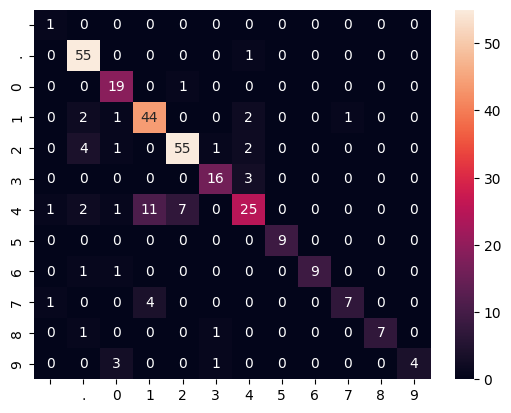

In [17]:
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

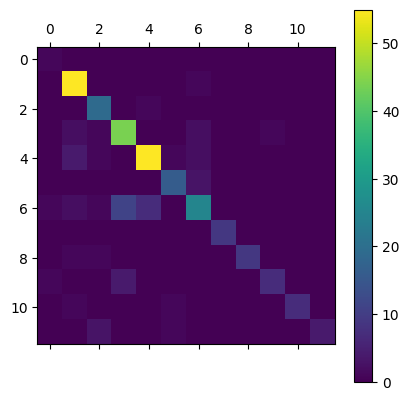

In [18]:
plt.matshow(matrix)
plt.colorbar()
plt.show()

In [19]:
print(f'Classification Report: {report}')

Classification Report:               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.85      0.98      0.91        56
           2       0.73      0.95      0.83        20
           3       0.75      0.88      0.81        50
           4       0.87      0.87      0.87        63
           5       0.84      0.84      0.84        19
           6       0.76      0.53      0.62        47
           7       1.00      1.00      1.00         9
           8       1.00      0.82      0.90        11
           9       0.88      0.58      0.70        12
          10       1.00      0.78      0.88         9
          11       1.00      0.50      0.67         8

    accuracy                           0.82       305
   macro avg       0.83      0.81      0.79       305
weighted avg       0.83      0.82      0.82       305



In [27]:
with open(MODEL_NAME, 'wb') as file:
    pickle.dump(f'{MODEL_NAME}', file)

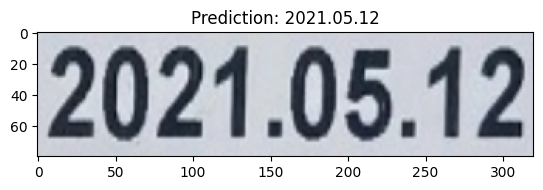

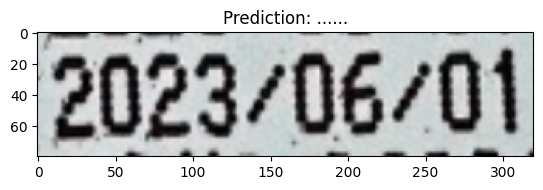

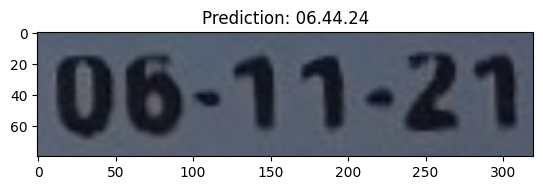

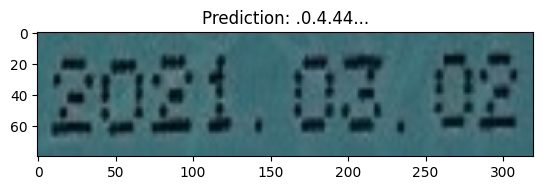

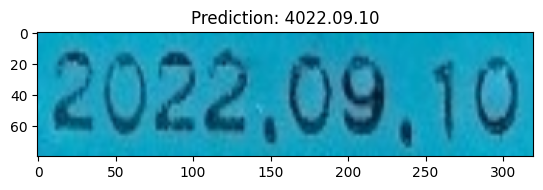

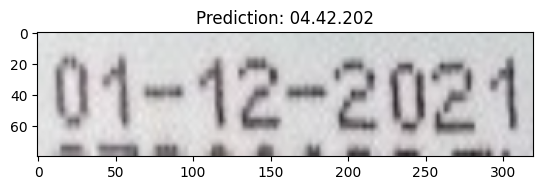

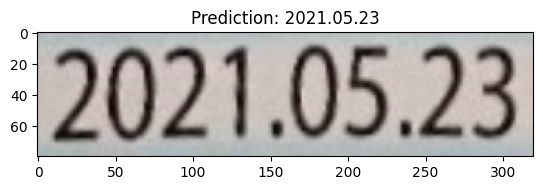

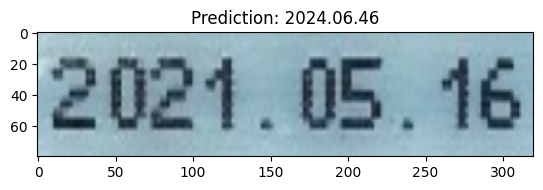

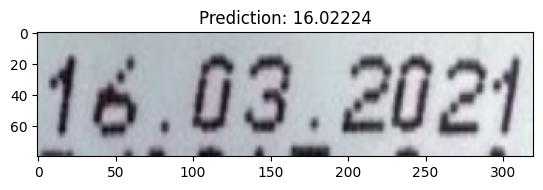

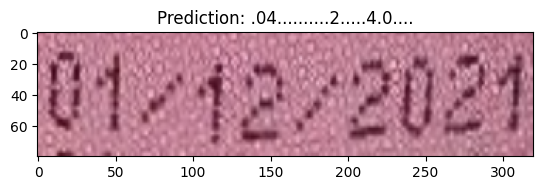

In [139]:
images = os.listdir(DATASET_PATH)[:10]

random.shuffle(images)

image_data = []

for index, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)

    image, original_image = preprocess_date_image(original_image)

    segmented_images = segment_image(image)

    segmented_images = [image.flatten() for image in segmented_images]

    prediction = model.predict(segmented_images)

    plt.imshow(original_image)
    plt.title(f'Prediction: {"".join([classes[p] for p in prediction])}')
    plt.show()